In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms, datasets
from torch.utils.data import DataLoader



In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Define source and target paths
input_path = '../datasets/IMFDB_final'
output_path = '../datasets/final_dataset'

# Train/test split ratio
train_ratio = 0.8

# Ensure train/test directories exist
os.makedirs(os.path.join(output_path, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_path, 'test'), exist_ok=True)

# Process each class (person) in the source dataset
for person in tqdm(os.listdir(input_path), desc="Processing Classes", unit="class"):
    person_folder = os.path.join(input_path, person)
    if os.path.isdir(person_folder):
        # Collect all image files for the current person from nested folders
        image_paths = []
        for root, _, files in os.walk(person_folder):
            for file in files:
                if file.lower().endswith(('jpg', 'jpeg', 'png', 'bmp')):  # Ensure it's an image
                    image_paths.append(os.path.join(root, file))

        # Split images into train and test
        train_images, test_images = train_test_split(image_paths, train_size=train_ratio, random_state=42)

        # Create train/test folders for the current class
        train_person_folder = os.path.join(output_path, 'train', person)
        test_person_folder = os.path.join(output_path, 'test', person)
        os.makedirs(train_person_folder, exist_ok=True)
        os.makedirs(test_person_folder, exist_ok=True)

        # Copy train images
        for img_path in tqdm(train_images, desc=f"Copying Train Images for {person}", leave=False, unit="image"):
            shutil.copy(img_path, train_person_folder)

        # Copy test images
        for img_path in tqdm(test_images, desc=f"Copying Test Images for {person}", leave=False, unit="image"):
            shutil.copy(img_path, test_person_folder)

print("Dataset flattened and split into train/test successfully!")


Processing Classes: 100%|██████████| 101/101 [00:09<00:00, 10.11class/s]

Dataset flattened and split into train/test successfully!


In [15]:
# Step 1: Set up the device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

# Step 2: Load the pretrained FaceNet model
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

count=0
# Print model architecture to inspect the layers
for name, layer in facenet.named_children():
    count+=1

print(count)

# Step 3: Freeze the pretrained layers (optional)
for param in facenet.parameters():
    param.requires_grad = True


18


In [16]:
# Step 4: Add a new classification head
class FaceClassifier(nn.Module):
    def __init__(self, facenet, num_classes):
        super(FaceClassifier, self).__init__()
        self.facenet = facenet
        self.fc = nn.Linear(512, num_classes)  # Output dimension matches the number of classes

    def forward(self, x):
        embeddings = self.facenet(x)  # Extract embeddings
        out = self.fc(embeddings)     # Pass embeddings to classification head
        return out

# Example: Suppose we have 5 classes
num_classes = 5
model = FaceClassifier(facenet, num_classes).to(device)

# Step 5: Set up the training components
criterion = nn.CrossEntropyLoss()  # For classification tasks
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Optimize only the classification head

# Step 6: Prepare the data
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to match pretrained model expectations
])

# Load dataset (replace with your dataset path)
train_dataset = datasets.ImageFolder(root='../datasets/final_dataset/train', transform=transform)
test_dataset = datasets.ImageFolder(root='../datasets/final_dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [17]:
from tqdm import tqdm

# Step 7: Training Loop with tqdm
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        # Use tqdm to wrap the data loader
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # Update progress bar description with the current loss
            progress_bar.set_postfix(loss=loss.item())

        # Print epoch loss
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


In [10]:
train_model(model, train_loader, criterion, optimizer)


Epoch 1/10: 100%|██████████| 596/596 [05:33<00:00,  1.79batch/s, loss=0]      


Epoch 1/10, Loss: 0.0609


Epoch 2/10: 100%|██████████| 596/596 [10:12<00:00,  1.03s/batch, loss=0]      


Epoch 2/10, Loss: 0.0390


Epoch 3/10: 100%|██████████| 596/596 [11:14<00:00,  1.13s/batch, loss=0]       


Epoch 3/10, Loss: 0.0310


Epoch 4/10:  37%|███▋      | 221/596 [05:04<08:05,  1.30s/batch, loss=0.0335]  

In [11]:
# Step 8: Evaluate the Model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate the model
evaluate_model(model, test_loader)

Test Accuracy: 4.95%


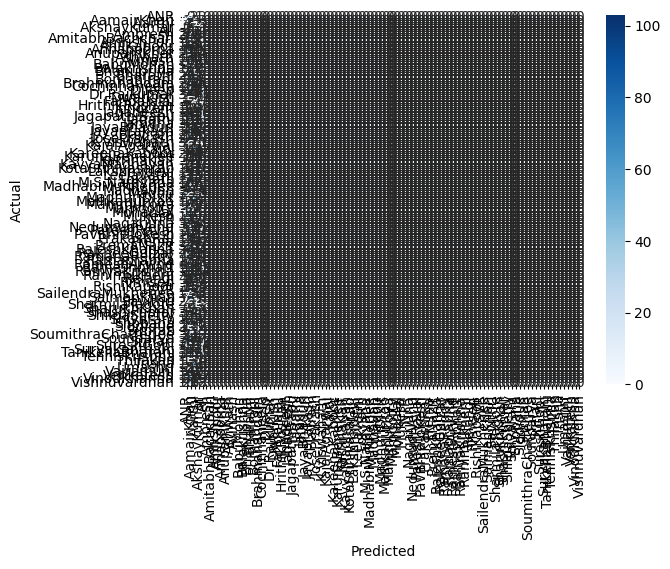

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# After evaluation, call the function to plot confusion matrix
plot_confusion_matrix(model, test_loader)


In [ ]:
# Save the trained model's state dictionary
model_save_path = "../models/inception_vggface2_imfdb.pth"  # Path to save the model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")
